In [1]:
from fastai.data.all import *

In [2]:
vocab_sz = 50
n_hidden = 48
n_heads = 8
bs = 64
seq_len = 18

In [3]:
sample_batch = torch.randint(vocab_sz, (bs, seq_len))
sample_batch.shape

torch.Size([64, 18])

In [4]:
emb = nn.Embedding(vocab_sz, n_hidden)
sample_emb = emb(sample_batch)
sample_emb.shape

torch.Size([64, 18, 48])

In [5]:
def positional_embeddings(seq_len, d_model):
    pos, i = torch.arange(d_model)[None, :], torch.arange(seq_len)[:, None]
    angle = pos / torch.pow(10000, 2 * i / d_model)
    pos_emb = torch.zeros(angle.shape)
    pos_emb[0::2,:], pos_emb[1::2,:] = angle[0::2,:].sin(), angle[1::2,:].cos()
    return pos_emb

In [6]:
pos_emb = positional_embeddings(seq_len, n_hidden)
pos_emb.shape

torch.Size([18, 48])

In [7]:
sample_in = sample_emb + pos_emb
sample_in.shape

torch.Size([64, 18, 48])

In [8]:
class SelfAttention(nn.Module):
    def __init__(self, ni, nheads):
        super(SelfAttention, self).__init__()
        self.heads = nheads
        self.scale = math.sqrt(ni / nheads)
        self.kqv = nn.Linear(ni, ni*3)
        self.proj = nn.Linear(ni, ni)
        self.norm = nn.LayerNorm(ni)
        
    def forward(self, inp):
        x = self.kqv(inp)
        x = torch.cat(torch.chunk(x, self.heads, dim=-1))
        Q, K, V = torch.chunk(x, 3, dim=-1)
        x = F.softmax(Q @ K.transpose(1,2) / self.scale, dim=-1) @ V
        x = torch.cat(torch.chunk(x, self.heads), dim=-1)
        x = self.proj(x)
        x = x + inp
        return self.norm(x)

In [9]:
class ResConv(nn.Module):
    def __init__(self, ni, fs):
        super(ResConv, self).__init__()
        self.conv = nn.Conv1d(ni, fs, kernel_size=3, padding=1)
        self.norm = nn.LayerNorm(ni)
        
    def forward(self, inp):
        x = self.conv(inp.transpose(1,2))
        x = x.transpose(1,2) + inp
        return self.norm(x)

In [10]:
att = SelfAttention(n_hidden, n_heads)
att_out = att(sample_in)
att_out.shape

torch.Size([64, 18, 48])

In [11]:
res = ResConv(n_hidden, 1000)
res_out = res(att_out)
res_out.shape

RuntimeError: The size of tensor a (1000) must match the size of tensor b (48) at non-singleton dimension 2

In [ ]:
class FeedForwardTransformer(nn.Module):
    def __init__(self, ni, nheads):
        super(FeedForwardTransformer, self).__init__()
        self.attention = SelfAttention(ni, nheads)
        self.resconv = ResConv(ni)
    def forward(self, inp):
        x = self.attention(inp)
        x = self.resconv(x)
        return x

In [ ]:
fft = FeedForwardTransformer(n_hidden, n_heads)
fft_out = fft(sample_in)
fft_out.shape

In [ ]:
sample_duration = torch.randint(1, 10, size=(bs, seq_len,))
sample_duration

In [ ]:
# fft_out[0].repeat_interleave(sample_duration[0], dim=1).shape, sample_duration.sum()

In [ ]:
for i in range(fft_out.size(0)):
    fftfft_out[i].repeat_interleave(sample_duration[i], dim=0)

In [12]:
alpha = 1
(sample_duration * alpha).to(torch.int)

NameError: name 'sample_duration' is not defined

In [13]:
def length_regulator(inp, durations, upsample_ratio, dim=1):
    adjusted_durations = (upsample_ratio * sample_duration).to(torch.int)
    return inp.repeat_interleave(adjusted_durations, dim=dim)

In [14]:
lr_out = length_regulator(fft_out, sample_duration, alpha)
lr_out.shape

NameError: name 'fft_out' is not defined

In [241]:
lr_out.shape[-2:]

torch.Size([99, 48])

In [242]:
pos_emb = positional_embeddings(*lr_out.shape[-2:])
pos_emb.shape

torch.Size([99, 48])

In [243]:
pos_out = lr_out + pos_emb
pos_out.shape

torch.Size([64, 99, 48])

In [244]:
fft_m = FeedForwardTransformer(n_hidden, n_heads)
fft_out = fft_m(pos_out)
fft_out.shape

torch.Size([64, 99, 48])

In [245]:
n_bins = 128

In [246]:
lin = nn.Linear(n_hidden,n_bins)

In [247]:
lin(fft_out).shape

torch.Size([64, 99, 128])

In [248]:
class FastSpeech(nn.Module):
    def __init__(self, vocab_sz, nhidden, nout, nheads, nblocks):
        super(FastSpeech, self).__init__()
        self.embedding = nn.Embedding(vocab_sz, nhidden)
        self.fft_pho = nn.ModuleList([FeedForwardTransformer(nhidden, nheads)
                                      for _ in range(nblocks)])
        self.fft_mel = nn.ModuleList([FeedForwardTransformer(nhidden, nheads)
                                      for _ in range(nblocks)])
        self.linear = nn.Linear(nhidden, nout)
    
    def forward(self, inp, durations, upsample_ratio):
        x = self.embedding(inp)
        x = x + positional_embeddings(*x.shape[-2:])
        for layer in self.fft_pho:
            x = layer(x)
        x = length_regulator(x, durations, upsample_ratio)
        x = x + positional_embeddings(*x.shape[-2:])
        for layer in self.fft_mel:
            x = layer(x)
        x = self.linear(x)
        return x

In [249]:
model = FastSpeech(vocab_sz, n_hidden, n_bins, n_heads, 6)

In [252]:
pred = model(sample_batch, sample_duration, alpha)
pred.shape

torch.Size([64, 99, 128])

In [260]:
import librosa

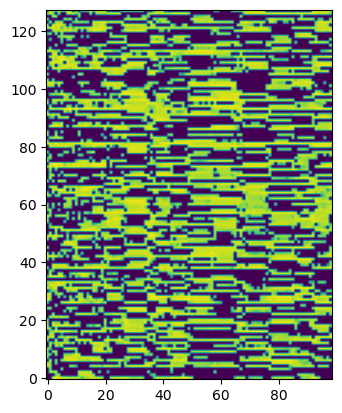

In [262]:
sample_pred = pred[0].T.detach().numpy()
plt.imshow(librosa.power_to_db(sample_pred), origin="lower");